In [8]:
import numpy as np
from scipy.stats import lognorm, norm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import cuqi
from cuqi.distribution import Laplace, Gaussian, JointDistribution
from cuqi.problem import BayesianProblem

## Case study: UQ for stochastic optical reconstruction microscopy (STORM)

In this case study we perform uncertainty quantification in molecule positions when using STORM.

STORM is a super-resolution microscopy method based on single-molecule stochastic switching, where the goal is to detect molecule positions in live cell imaging. The images are obtained by a microscope detecting the photon count of the (fluorescence) photoactivated molecules.

The original, deterministic, problem is described in [1]. In this notebook, we perform uncertainty quantification on the molecule positions. To this end, we consider the problem in the Bayesian context, and we use the same problem formulation as in [2].


### Parameters

In [9]:
# parameters
par = \
{'N': 50, # number of molecules
 's_data': 32, # side length of data image
 's_mol': 24, # side length of area in data image where molecules are located
 'R': 4, # super-resolution factor
 'mode': 3000, # mode of lognormal distribution of molecule photon count
 'ph_back': 70, # photon background count
 'noise_std': 30, # standard deviation of noise
 'pad_width': 1, # for boundary conditions of blurring kernel of instrument
 'ext_mode': 'periodic', # boundary condition of blurring kernel
 'lognorm_std': 0.417, # standard deviation of lognormal distribution of photon count
 'ind_mol_seed': 0, # seed for generation of true molecule positions
 'N_pho_seed': 1, # seed for generation of true photon count of molecules
 'noise_seed': 2, # seed for noise
 'delta': 1.275, # rate parameter of Laplace prior
}

# ravel/unravel image/vector in column-wise fashion
rav = lambda x: np.ravel(x, order='F')
unrav = lambda x, s: np.reshape(x, newshape=(s,s), order='F')

### Gound truth and data

SNR=212.7291967962976


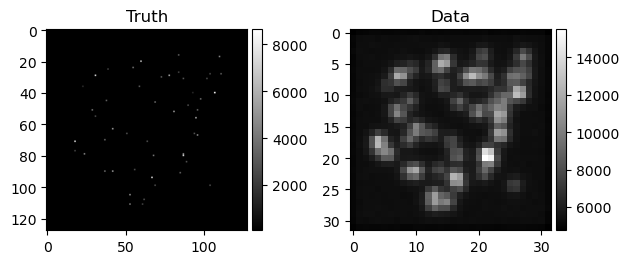

In [10]:
## generate ground truth

# true molecule positions
x_im_truth = np.zeros((par['s_mol']*par['R'], par['s_mol']*par['R'])) # true image of molecules in super-resolution
np.random.seed(par['ind_mol_seed'])
ind_mol_crop = np.random.choice(np.arange(x_im_truth.size), size=par['N'], replace=False) # indices of molecule positions

# true photon counts
lognorm_mean = np.log(par['mode']) + par['lognorm_std']**2 # mean of lognormal distribution based on [1]
np.random.seed(par['N_pho_seed'])
N_pho = lognorm.rvs(loc=0, s=par['lognorm_std'], scale=np.exp(lognorm_mean), size=par['N']) # photons count of molecules

# place photons in super-resolution image
x_im_truth[np.unravel_index(ind_mol_crop, shape=(x_im_truth.shape[0], x_im_truth.shape[1]), order='F')] = N_pho
x_im_truth = np.pad(x_im_truth, (par['s_data']-par['s_mol'])//2*par['R'], mode='constant', constant_values=0) # no molecules in this area
ind_mol = np.nonzero( rav( (x_im_truth > np.zeros((par['s_data']*par['R'], par['s_data']*par['R']))) ) )[0] # indices of molecules in column-stacked vector

# add background photon count
x_im_truth += par['ph_back']


## simulate data

# load blurring matrix
file = open(r'A_4x32_cent', 'rb')
A_mat = pickle.load(file)
file.close()

# true data
y_truth = A_mat @ rav(x_im_truth)

# noise
np.random.seed(par['noise_seed'])
N_pho_noise = norm.rvs(scale=par['noise_std'], size=par['s_data']**2)
y = y_truth + N_pho_noise
print(f"SNR={np.linalg.norm(y)/np.sqrt(y.size)/par['noise_std']}") # signal-to-noise-ratio


## plot truth and data

fig, ax = plt.subplots(ncols=2)

# truth
im = ax[0].imshow(x_im_truth, cmap='gray')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
ax[0].set_title('Truth')
fig.colorbar(im, cax=cax, orientation='vertical')

# data
im = ax[1].imshow(unrav(y, par['s_data']), cmap='gray')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
ax[1].set_title('Data')
fig.colorbar(im, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

### Bayesian inverse problem

In [11]:
class LaplaceSmoothed():
    def __init__(self, dim, location, scale, beta, **kwargs):
        self.dim = dim
        self.location = location
        self.scale = scale
        self.beta = beta
  
    def logpdf(self, x):
        if isinstance(x, (float,int)):
            x = np.array([x])
        return self.dim*(np.log(0.5/self.scale)) - np.sum(np.sqrt((x-self.location)**2+self.beta))/self.scale

    def gradient(self, val):
        if isinstance(val, (float,int)):
            val = np.array([val])
        return -np.array((val - self.location)/self.scale/np.sqrt((val-self.location)**2+self.beta))


In [12]:
# prior
d = ( par['s_data']*par['R'] )**2 # dimension of problem
beta = 1e-3
mylaplace= LaplaceSmoothed(d, np.zeros(d), 1/par['delta'], beta)
X=cuqi.distribution.UserDefinedDistribution(dim=d, logpdf_func=mylaplace.logpdf, gradient_func=mylaplace.gradient)

# X = Laplace(np.zeros(d), np.ones(d) * 1/par['delta']) # product-form Laplace prior (requires scale (inverse of rate))

model_mat = cuqi.model.LinearModel(A_mat)

Y = Gaussian(model_mat@X, cov= par['noise_std']**2 * np.ones(y.shape))

# # data model
# Y = Gaussian(mean=lambda X: A_mat@X, cov= par['noise_std']**2 * np.ones(d))

# joint distribution of X and Y
X_Y = JointDistribution(X, Y)
print(X_Y)

# posterior X|Y=y (condition X,Y on data y)
p = X_Y(Y=y)
print('\n')
print(p)
print(f"Posterior geometry: {p.geometry}")

# # posterior X|Y=y via cuqi.problem.BayesianProblem
# BP = BayesianProblem(X, Y)
# print('\n')
# print(BP)

JointDistribution(
    Equation: 
	p(X,Y) = p(X)p(Y|X)
    Densities: 
	X ~ CUQI UserDefinedDistribution.
	Y ~ CUQI Gaussian. Conditioning variables ['X'].
)


Posterior(
    Equation:
	 p(X|Y) ∝ L(X|Y)p(X)
    Densities:
	Y ~ CUQI Gaussian Likelihood function. Parameters ['X'].
 	X ~ CUQI UserDefinedDistribution.
 )
Posterior geometry: _DefaultGeometry1D(16384,)


In [ ]:
mala_sampler = cuqi.sampler.MALA(p, scale=0.01)
mala_samples = mala_sampler.sample(5000, 1000)

Text(0.5, 1.0, 'Posterior mean of MALA samples')

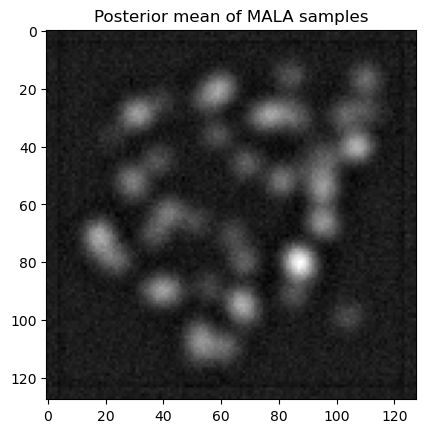

In [25]:
plt.imshow(unrav(mala_samples.mean(), 128), cmap='gray')
plt.title("Posterior mean of MALA samples")

Plotting 5 randomly selected samples


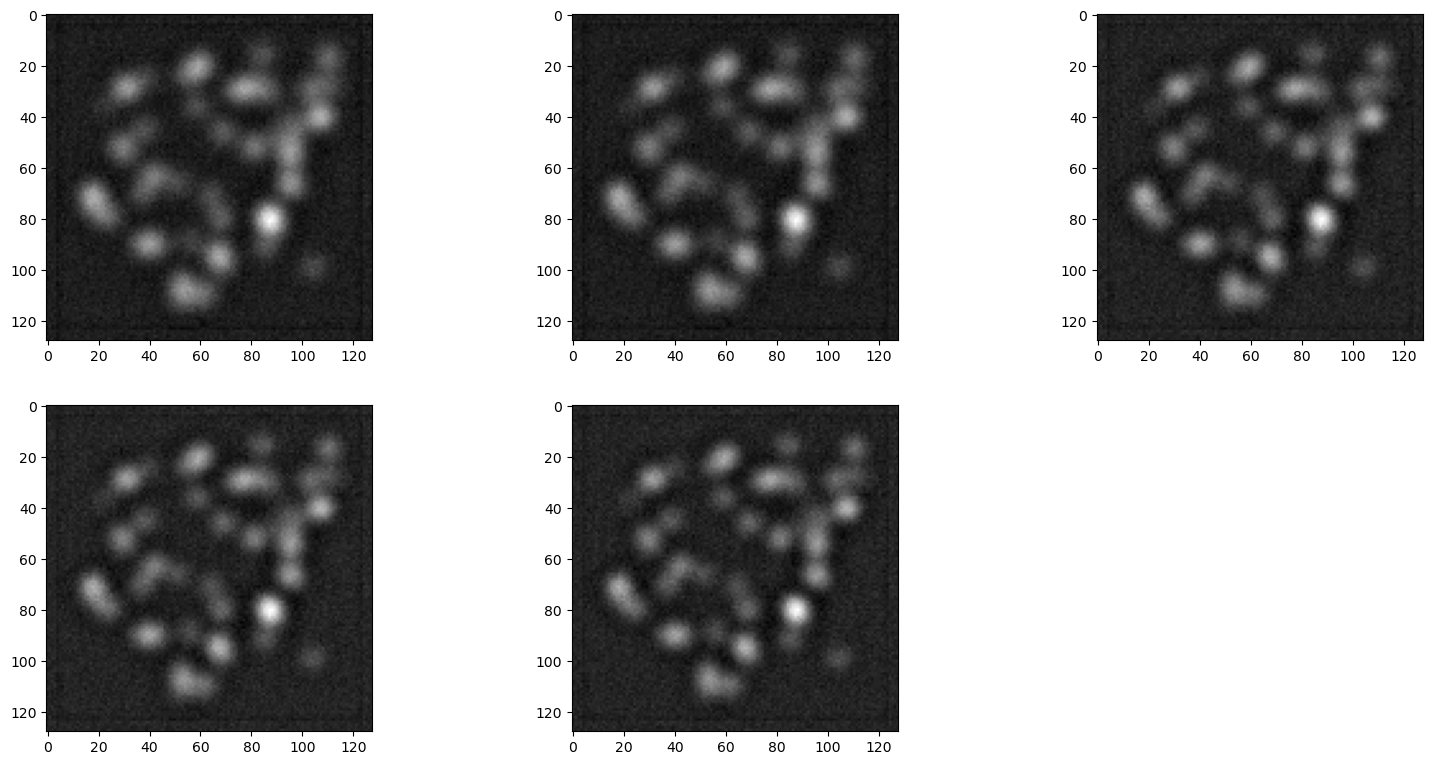

In [33]:
mala_samples.geometry = cuqi.geometry.Image2D((128,128), "F")
mala_samples.plot()

In [14]:
# nuts_sampler = cuqi.sampler.NUTS(p)
# nuts_samples = nuts_sampler.sample(1000, 100)
# plt.imshow(unrav(nuts_samples.mean(), 128), cmap='gray')

In [15]:
# BP = BayesianProblem(Y, X).set_data(Y=y)

# x_map = BP.MAP()

# plt.imshow(unrav(x_map, 128))

# x_samples = BP.sample_posterior(100)

### Sampling and sample statistics

[1]
Zhu, L., Zhang, W., Elnatan, D., Huang, B.: Faster STORM using compressed sensing. Nature Methods 9(7), 721–723 (2012) https://doi.org/10.1038/nmeth.1978

[2]
Flock, R., Dong, Y., Uribe, F., & Zahm, O.: Certified coordinate selection for high-dimensional Bayesian inversion with Laplace prior. Statistics and Computing. Under Review (2023). https://doi.org/10.21203/rs.3.rs-3471448/v1 

## test SmoothedLapalce

In [16]:
# import numpy as np
# import cuqi

# class LaplaceSmoothed():
#     def __init__(self, dim, location, scale, beta, **kwargs):
#         self.dim = dim
#         self.location = location
#         self.scale = scale
#         self.beta = beta
  
#     def logpdf(self, x):
#         if isinstance(x, (float,int)):
#             x = np.array([x])
#         return self.dim*(np.log(0.5/self.scale)) - np.sum(np.sqrt((x-self.location)**2+self.beta))/self.scale

#     def gradient(self, val):
#         if isinstance(val, (float,int)):
#             val = np.array([val])
#         return -np.array((val - self.location)/self.scale/np.sqrt((val-self.location)**2+self.beta))

# mylaplace = LaplaceSmoothed(2, np.array([0,0]),1,1e-2)

In [17]:
# cuqilaplace = cuqi.distribution.Laplace(np.array([0,0]), 1)

In [18]:
# x_test = np.array([1,1])
# cuqilaplace.logpdf(x_test)

In [19]:
# mylaplace.logpdf(x_test)

In [20]:
# (cuqilaplace.logpdf(np.array([3.001,1]))-cuqilaplace.logpdf(np.array([3,1])))/0.001

In [21]:
# mylaplace.gradient(np.array([3,1]))

In [22]:
# import matplotlib.pyplot as plt
# laplace = cuqi.distribution.Laplace(np.array([0]), np.array([1]))
# mylaplace = LaplaceSmoothed(1, np.array([0]),1,1e-2)
# x = np.linspace(-1,1,100)
# myy = np.zeros(x.shape)
# y = np.zeros(x.shape)
# for i in range(len(x)):
#     myy[i] = mylaplace.logpdf(x[i])
#     y[i] = laplace.logpdf(x[i])
# plt.plot(x,y, label='cuqi')
# plt.plot(x,myy, label='mine')